In [ ]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
plt.rcParams['font.family'] = 'Ms Gothic'

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# NumPyの浮動小数点の表示精度
np.set_printoptions(suppress = True, precision = 4)
# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format
# データフレームですべての項目を表示
pd.set_option('display.max_columns', None)
# グラフのデフォルトフォントの指定
plt.rcParams['font.size'] = 14
# 乱数の種
random_seed = 123


In [ ]:
# 混同行列表示用関数

def make_cm(matrix, columns):
    # matrix numpy配列

    # columns 項目名リスト
    n = len(columns)

    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n

    #データフレーム生成
    cm = pd.DataFrame(matrix,
        columns=[pred, columns], index=[act, columns])
    return cm


In [ ]:
#  day.csvをデータフレームに取り込む
# 日付を表す列はparse_datesで指定する
df = pd.read_csv('df1.csv', parse_dates=[0], encoding='Shift JIS')

# データ属性の確認
print(df.dtypes)

日付        datetime64[ns]
年                  int64
月                  int64
日                  int64
曜日                 int64
祝日                 int64
店休日                int64
平均気温             float64
最高気温             float64
最低気温             float64
降水量の合計           float64
日照時間             float64
積雪予測               int64
平均風速             float64
最大風速             float64
チラシ                int64
来客数                int64
dtype: object


In [ ]:

# 先頭5行の確認
display(df.head())

# 最終5行を確認
display(df.tail())


,日付,年,月,日,曜日,祝日,店休日,平均気温,最高気温,最低気温,降水量の合計,日照時間,積雪予測,平均風速,最大風速,チラシ,来客数
0,2020-12-01,2020,12,1,2,0,0,9.5000,14.6000,3.9000,0.0000,8.1000,0,1.6000,3.7000,0,2675
1,2020-12-02,2020,12,2,3,0,0,8.0000,10.5000,6.0000,3.5000,0.0000,0,2.6000,4.1000,1,2632
2,2020-12-03,2020,12,3,4,0,0,8.5000,10.7000,6.6000,0.5000,0.0000,0,2.1000,3.6000,1,2776
3,2020-12-04,2020,12,4,5,0,0,9.0000,13.7000,6.0000,0.0000,6.5000,0,2.1000,3.6000,1,2780
4,2020-12-05,2020,12,5,6,0,0,6.7000,8.1000,3.7000,4.5000,0.0000,0,2.0000,3.9000,1,2781


,日付,年,月,日,曜日,祝日,店休日,平均気温,最高気温,最低気温,降水量の合計,日照時間,積雪予測,平均風速,最大風速,チラシ,来客数
1090,2023-11-26,2023,11,26,0,0,0,8.2000,9.0000,6.7000,0.0000,0.0000,0,2.3000,4.0000,1,3160
1091,2023-11-27,2023,11,27,1,0,0,11.3000,16.7000,7.2000,0.0000,5.0000,0,1.2000,2.8000,1,3333
1092,2023-11-28,2023,11,28,2,0,0,15.7000,22.0000,6.6000,0.0000,9.3000,0,2.6000,6.6000,1,2796
1093,2023-11-29,2023,11,29,3,0,0,10.0000,17.2000,2.7000,0.0000,9.4000,0,1.6000,5.3000,1,2968
1094,2023-11-30,2023,11,30,4,0,0,10.1000,17.0000,4.7000,0.0000,5.8000,0,1.8000,3.8000,1,2693


In [ ]:
# 「日付」と「来客数」のみ抽出し、
# 列名を日付:ds 、来客数:y に置き換えたデータフレームdf2を作る

# データフレーム全体のコピー
df2 = df.copy()

# 「日付」「来客数」列の抽出
df2 = df2[['日付', '来客数']]

# 列名の置き換え
df2.columns = ['ds', 'y']

# 結果確認
display(df2.head())

,ds,y
0,2020-12-01,2675
1,2020-12-02,2632
2,2020-12-03,2776
3,2020-12-04,2780
4,2020-12-05,2781


In [ ]:
# 分割日 mdayの設定
# '2023-04-01'
# '2022-12-01'
# '2023-06-01'
# '2023-09-01'
mday = pd.to_datetime('2023-09-01')

# 訓練用indexと検証用indexを作る
train_index = df2['ds'] < mday
test_index = df2['ds'] >= mday

# 入力データの分割
x_train = df2[train_index]
x_test = df2[test_index]

# 日付データの分割(グラフ表示用)
dates_test = df2['ds'][test_index]

In [ ]:
# ライブラリのimport
from prophet import Prophet

# モデル選定
# 3つのseasonalityパラメータの設定が重要
# 今回のデータの場合、日単位のデータなのでdaily_seasonalityは不要
# weekly_seasonality とdaily_seasonalityは
# True / Falseの他に数値で指定することも可能 (三角関数の個数)
# seasonality_mode: additive(デフォルト) multiplicative

m1 = Prophet(yearly_seasonality=True, weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative')

In [ ]:


import pystan
# 学習
m1.fit(x_train)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnip3uhxb/sil8tvtb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnip3uhxb/v56bjyf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59167', 'data', 'file=/tmp/tmpnip3uhxb/sil8tvtb.json', 'init=/tmp/tmpnip3uhxb/v56bjyf1.json', 'output', 'file=/tmp/tmpnip3uhxb/prophet_model5yuwutc7/prophet_model-20240129054804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:48:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:48:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
pip install japanize-matplotlib

In [ ]:
import japanize_matplotlib

In [ ]:

# 予測用データの作成
# （日付dsだけが入ったデータフレーム）
# 2023-04-01 : 244
# 2022-12-01 : 365
# 2023-06-01 : 183
# 2023-09-01 : 91
future1 = m1.make_future_dataframe(periods = 91, freq = 'D')

# 結果確認
display(future1.head())
display(future1.tail())


,ds
0,2020-12-01
1,2020-12-02
2,2020-12-03
3,2020-12-04
4,2020-12-05


,ds
1090,2023-11-26
1091,2023-11-27
1092,2023-11-28
1093,2023-11-29
1094,2023-11-30


In [ ]:
# 予測
# 結果はデータフレームで戻ってくる
fcst1 = m1.predict(future1)

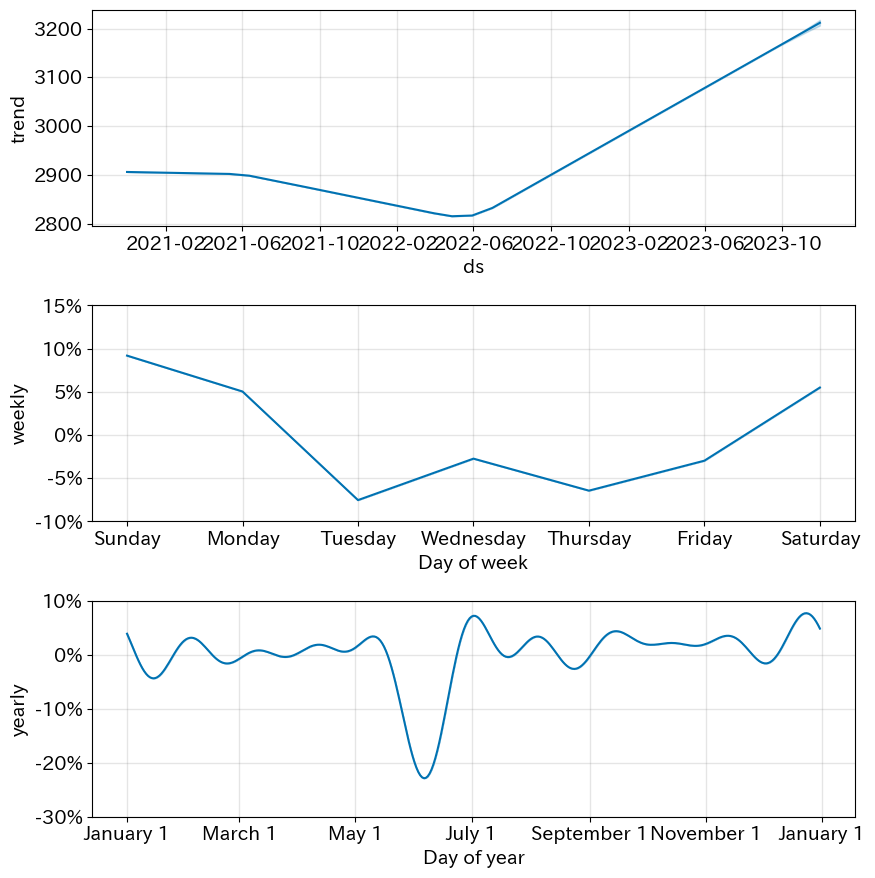

In [ ]:
# 要素ごとのグラフ描画
# この段階ではトレンド、週周期、年周期
fig = m1.plot_components(fcst1)
plt.show()


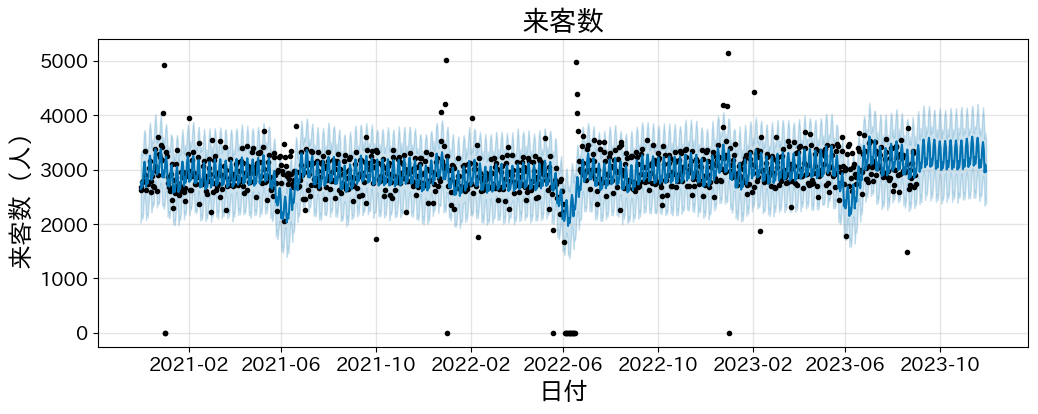

In [ ]:
# 訓練データ・検証データ全体のグラフ化
import japanize_matplotlib
fig, ax = plt.subplots(figsize = (12, 4))

# 予測結果のグラフ表示(prophetの関数)
m1.plot(fcst1, ax = ax)

# タイトル設定など
ax.set_title('来客数', size = 20)
ax.set_xlabel('日付', size = 18)
ax.set_ylabel('来客数（人）', size = 18)

# グラフ表示
plt.show()


In [ ]:

# ypred1:fcst1から予測部分のみ抽出する。
# 2023-04-01 : -244
# 2022-12-01 : -365
# 2023-06-01 : -183
# 2023-09-01 : -91
ypred1 = fcst1[-91:][['yhat']].values

# ytest1:予測期間中の正解データ
ytest1 = x_test['y'].values

# R2値の計算
from sklearn.metrics import r2_score
score = r2_score(ytest1, ypred1)

# 結果確認
print(f'R2 score:{score:.4f}')

R2 score:-0.2111


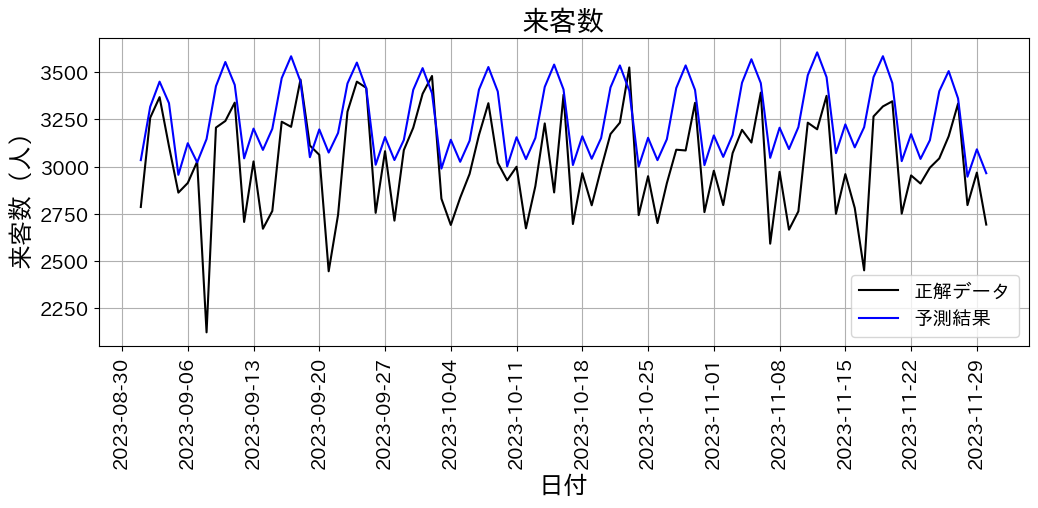

In [ ]:

# 時系列グラフの描画
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize = (12, 4))

# グラフ描画
ax.plot(dates_test, ytest1, label = '正解データ', c = 'k')
ax.plot(dates_test, ypred1, label = '予測結果', c = 'b')

# 日付目盛間隔
# 水曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday = mdates.WE)
ax.xaxis.set_major_locator(weeks)

# 日付表示を90度回転
ax.tick_params(axis = 'x', rotation = 90)

# 軸ラベル
ax.set_xlabel('日付', size = 18)
ax.set_ylabel('来客数（人）', size = 18)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('来客数', size = 20)

# 画像出力
plt.show()

In [ ]:
# 休日の抽出
df_holiday = df[df['店休日'] == 1]
holidays = df_holiday['日付'].values

# データフレーム形式に変換
df_add = pd.DataFrame({'holiday': 'holi', 'ds': holidays, 'lower_window': 0, 'upper_window': 0})

# 結果確認
display(df_add.head())
display(df_add.tail())


,holiday,ds,lower_window,upper_window
0,holi,2021-01-01,0,0
1,holi,2021-01-02,0,0
2,holi,2022-01-01,0,0
3,holi,2022-05-19,0,0
4,holi,2022-06-03,0,0


,holiday,ds,lower_window,upper_window
14,holi,2022-06-13,0,0
15,holi,2022-06-14,0,0
16,holi,2022-06-15,0,0
17,holi,2022-06-16,0,0
18,holi,2023-01-01,0,0


In [ ]:
# 店休日（df_add）をモデルの入力とする

# アルゴリズム選択
# holidysパラメータを追加してモデルm2を生成
m2 = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = False,
            holidays = df_add, seasonality_mode = 'multiplicative')

# 学習
m2 = m2.fit(x_train)

# 予測
fcst2 = m2.predict(future1)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnip3uhxb/bcmx1a1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnip3uhxb/tze4lkun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93283', 'data', 'file=/tmp/tmpnip3uhxb/bcmx1a1l.json', 'init=/tmp/tmpnip3uhxb/tze4lkun.json', 'output', 'file=/tmp/tmpnip3uhxb/prophet_modelfjdksq8l/prophet_model-20240129054821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:48:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:48:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


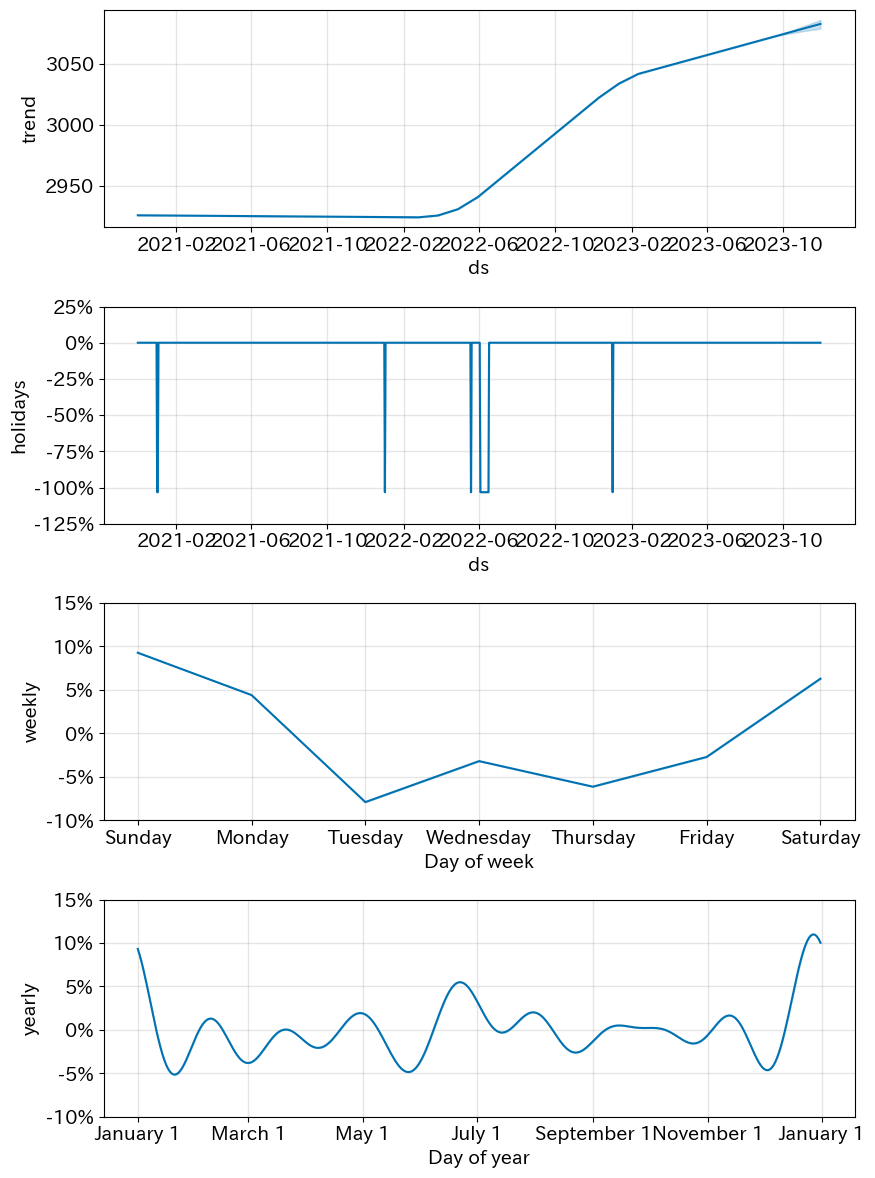

In [ ]:

# 要素ごとのグラフ描画
fig = m2.plot_components(fcst2)
plt.show()

In [ ]:

# R値の計算

# fcst2から予測部分のみ抽出する
# 2023-04-01 : -244
# 2022-12-01 : -365
# 2023-06-01 : -183
# 2023-09-01 : -91
ypred2 = fcst2[-91:][['yhat']].values

# R2値の計算
score2 = r2_score(ytest1, ypred2)

# 結果確認
r2_text2 = f'R2 score:{score2:.4f}'
print(r2_text2)


R2 score:0.5078


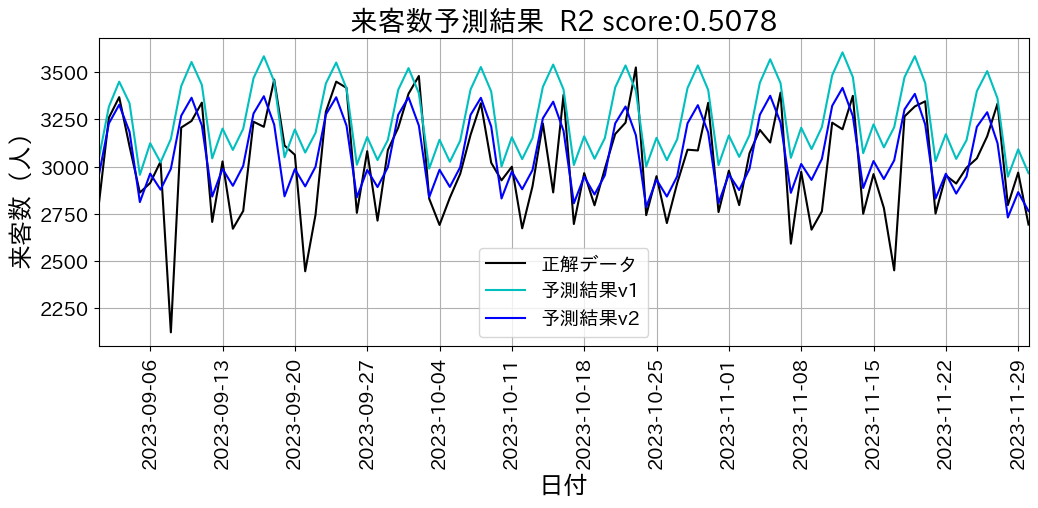

In [ ]:
# 時系列グラフの描画
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12, 4))

# グラフ描画
ax.plot(dates_test, ytest1, label='正解データ', c='k')
ax.plot(dates_test, ypred1, label='予測結果v1', c='c')
ax.plot(dates_test, ypred2, label='予測結果v2', c='b')

# 日付目盛間隔
# 水曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.WE)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 開始日と終了日
# 2023-04-01:'2023-04-01'
# 2022-12-01:'2022-12-01'
# 2023-06-01:'2023-06-01'
# 2023-09-01:'2023-09-01'
sday = pd.to_datetime('2023-09-01')

# 2023-04-01:'2023-11-30'
# 2022-12-01:'2023-11-30'
# 2023-06-01:'2023-11-30'
# 2023-09-01:'2023-11-30'
eday = pd.to_datetime('2023-11-30')
ax.set_xlim(sday, eday)

# 軸ラベル
ax.set_xlabel('日付', size = 18)
ax.set_ylabel('来客数（人）', size = 18)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('来客数予測結果  ' + r2_text2, size = 20)

# 画面出力
plt.show()

In [ ]:
# 学習データに「天気」「気温」「風速」「湿度」を追加
df3 = pd.concat([df2, df[['祝日', '平均気温', '最高気温', '最低気温', '降水量の合計', '日照時間', '積雪予測',
                          '平均風速', '最大風速', 'チラシ']]], axis = 1)

# 入力データの分割
x2_train = df3[train_index]
x2_test = df3[test_index]

# 結果確認
display(x2_train.tail())


,ds,y,祝日,平均気温,最高気温,最低気温,降水量の合計,日照時間,積雪予測,平均風速,最大風速,チラシ
999,2023-08-27,3302,0,27.7000,33.0000,23.9000,0.0000,5.6000,0,2.2000,3.9000,1
1000,2023-08-28,3338,0,29.0000,34.3000,24.8000,0.0000,5.3000,0,1.9000,4.0000,0
1001,2023-08-29,2671,0,28.9000,33.6000,24.9000,0.0000,11.9000,0,2.3000,5.4000,0
1002,2023-08-30,2899,0,28.5000,32.8000,23.5000,0.0000,10.2000,0,2.3000,4.5000,1
1003,2023-08-31,2736,0,28.6000,32.7000,25.5000,0.0000,9.2000,0,2.9000,5.1000,1


In [ ]:

# アルゴリズム選択

m3 = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = False,
             seasonality_mode = 'multiplicative', holidays = df_add)

# add_regressor関数で、「天気」「気温」「湿度」をモデルに組み込む
m3.add_regressor('祝日')
m3.add_regressor('平均気温')
m3.add_regressor('最高気温')
m3.add_regressor('最低気温')
m3.add_regressor('降水量の合計')
m3.add_regressor('日照時間')
m3.add_regressor('積雪予測')
m3.add_regressor('平均風速')
m3.add_regressor('最大風速')
m3.add_regressor('チラシ')


# 学習
m3.fit(x2_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnip3uhxb/5414uasd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnip3uhxb/285hho7c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10882', 'data', 'file=/tmp/tmpnip3uhxb/5414uasd.json', 'init=/tmp/tmpnip3uhxb/285hho7c.json', 'output', 'file=/tmp/tmpnip3uhxb/prophet_modelw7ju6fjg/prophet_model-20240129054824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:48:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:48:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:

# 予測用の入力データを作る
future3 = df3[['ds', '祝日', '平均気温', '最高気温', '最低気温', '降水量の合計', '日照時間', '積雪予測',
                          '平均風速', '最大風速', 'チラシ']]

# 予測
fcst3 = m3.predict(future3)


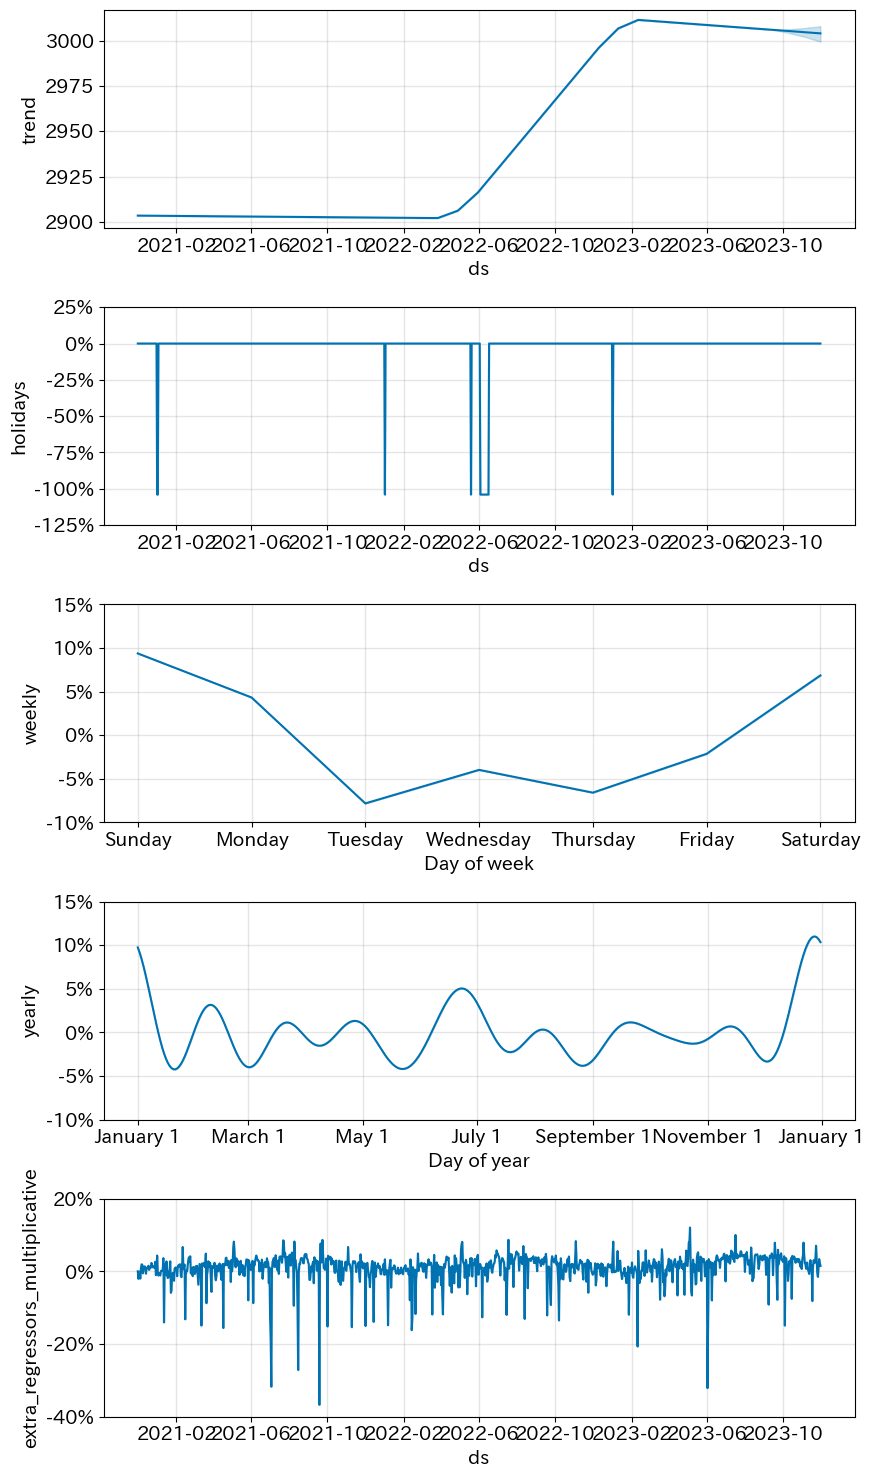

In [ ]:
# 要素ごとのグラフ描画
fig = m3.plot_components(fcst3)
plt.show()

In [ ]:
# R値の計算

# fcstから予測部分のみ抽出する
# 2023-04-01 : -244
# 2022-12-01 : -365
# 2023-06-01 : -183
# 2023-09-01 : -91
ypred3 = fcst3[-91:][['yhat']].values
score3 = r2_score(ytest1, ypred3)

# 結果確認
r2_text3 = f'R2 score:{score3:.4f}'
print(r2_text3)


R2 score:0.6986


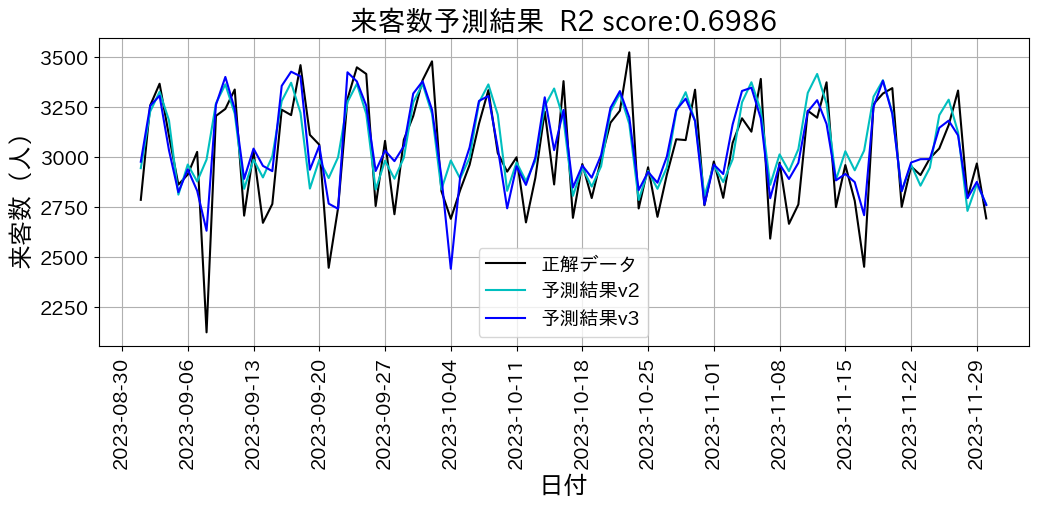

In [ ]:
# 時系列グラフの描画
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12, 4))

# グラフ描画
ax.plot(dates_test, ytest1, label='正解データ', c='k')
ax.plot(dates_test, ypred2, label='予測結果v2', c='c')
ax.plot(dates_test, ypred3, label='予測結果v3', c='b')

# 日付目盛間隔
# 水曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.WE)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 軸ラベル
ax.set_xlabel('日付', size = 18)
ax.set_ylabel('来客数（人）', size = 18)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('来客数予測結果  ' + r2_text3, size = 20)

# 画面出力
plt.show()